#### **Regression-Analysis-Team-Project** by Team 1

### [Kaggle competition] 
# Zillow Prize: Zillow’s Home Value Prediction (Zestimate)
### Can you improve the algorithm that changed the world of real estate?

## **1. Data Introduce**

## **2. EDA - Exploring the Data!**

#### Importing necessary libraries

In [1]:
####### what's in startup file #######
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in 

##### 설치가 필요한 패키지
- missingno: `$ pip install missingno`
- folium:

In [2]:
####### what's not in startup file #######
from scipy import stats
import missingno as msno

# visualization in jupyter
%matplotlib inline   

# ignore warning messeges
import warnings
warnings.filterwarnings('ignore')

# excel file
import xlrd
import openpyxl

import time

# plotting on map
import folium

#### Importing Data

##### (1) Properties Data

In [3]:
prop16 = pd.read_csv('data/properties_2016.csv')

In [4]:
prop17 = pd.read_csv('data/properties_2017.csv')

##### (2) Train Data

In [5]:
train16 = pd.read_csv('data/train_2016_v2.csv', parse_dates=["transactiondate"])

In [6]:
train17 = pd.read_csv('data/train_2017.csv', parse_dates=["transactiondate"])

#### (3) Merging Train and Properties Data

In [7]:
# traing16을 기준으로 prop16을 merge
merged16 = pd.merge(train16, prop16, on="parcelid", how="left")

In [8]:
# traing17을 기준으로 prop17을 merge
merged17 = pd.merge(train17, prop17, on="parcelid", how="left")

In [9]:
merged = pd.concat([merged16, merged17]).reset_index(drop=True)
merged.tail()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
167883,10833991,-0.002245,2017-09-20,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,NaN,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,NaN,6.037132e+13
167884,11000655,0.020615,2017-09-20,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13
167885,17239384,0.013209,2017-09-21,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,1.0,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13
167886,12773139,0.037129,2017-09-21,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,NaN,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13
167887,12826780,0.007204,2017-09-25,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,NaN,NaN,140000.0,522000.0,2016.0,382000.0,6317.15,NaN,NaN,6.037503e+13


#### (4) Status of merged data

##### Data의 format 등에 먼저 전처리를 해줄 수 있는 부분

In [10]:
# transaction date을 year와 month로 분리해 줌
merged['transaction_year'] = merged['transactiondate'].dt.year
merged['transaction_month'] = merged['transactiondate'].dt.month

# taxdelinquency는 "Y"를 1로 바꾸어 줌 (다른 dummy 변수들은 1이나 True로 되어 있음)
merged['taxdelinquencyflag'] = merged['taxdelinquencyflag'].replace('Y',1)

# taxdelinquencyyear는 4자리의 년도로 format을 맞춰줌
merged["taxdelinquencyyear"] = merged["taxdelinquencyyear"].apply(lambda x: x + 2000 if x <= 17 else x + 1900)

# 위도 경도를 원래 단위로 맞춰줌
merged["latitude"] = merged["latitude"]/1000000
merged["longitude"] = merged["longitude"]/1000000

In [11]:
merged_des = merged.describe(include='all').transpose()
merged_des["missing_ratio"] = 1-(merged_des["count"]/merged.shape[0])
merged_des["dtype"] = merged.dtypes
merged_des.reset_index()

,index,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
0,parcelid,167888,NaN,NaN,NaN,NaN,NaN,1.29954e+07,3.01607e+06,1.07117e+07,1.1549e+07,1.25406e+07,1.42193e+07,1.67689e+08,0,int64
1,logerror,167888,NaN,NaN,NaN,NaN,NaN,0.0139063,0.165706,-4.65542,-0.0253,0.006,0.0392,5.263,0,float64
2,transactiondate,167888,616,2017-06-30 00:00:00,1195,2016-01-01 00:00:00,2017-09-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,datetime64[ns]
3,airconditioningtypeid,53788,NaN,NaN,NaN,NaN,NaN,1.81435,2.97024,1,1,1,1,13,0.67962,float64
4,architecturalstyletypeid,468,NaN,NaN,NaN,NaN,NaN,7.29915,2.71963,2,7,7,7,21,0.997212,float64
5,basementsqft,93,NaN,NaN,NaN,NaN,NaN,695.376,583.952,38,280,588,819,3560,0.999446,float64
6,bathroomcnt,167854,NaN,NaN,NaN,NaN,NaN,2.28827,1.00084,0,2,2,3,20,0.000202516,float64
7,bedroomcnt,167854,NaN,NaN,NaN,NaN,NaN,3.04174,1.14913,0,2,3,4,16,0.000202516,float64
8,buildingclasstypeid,31,NaN,NaN,NaN,NaN,NaN,3.96774,0.179605,3,4,4,4,4,0.999815,float64
9,buildingqualitytypeid,107173,NaN,NaN,NaN,NaN,NaN,6.01546,1.8828,1,4,7,7,12,0.36164,float64


##### categorical / numerical variable 구분하기

In [12]:
vars = merged_des.reset_index()["index"].tolist()

cat_vars = ['transactiondate','rawcensustractandblock', 'censustractandblock', 'regionidcounty', 'regionidcity', 'regionidcounty', 'regionidneighborhood',
            'architecturalstyletypeid', 'decktypeid', 'buildingqualitytypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid',
            'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'taxdelinquencyflag', 'assessmentyear', 'heatingorsystemtypeid',
            'airconditioningtypeid', 'hashottuborspa', 'fireplaceflag', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7']
num_vars = [i for i in vars if i not in cat_vars]

num_vars.remove('parcelid')
num_vars.remove('logerror')

print("number of categorical variables:", len(cat_vars))
print("number of numerical variables:", len(num_vars))

number of categorical variables: 25
number of numerical variables: 36


##### 카테고리 변수가 float으로 되어 있는 경우 str으로 바꿔주기
- str: 'architecturalstyletypeid', 'rawcensustractandblock', 'censustractandblock', 'regionidcounty', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'decktypeid', 'buildingqualitytypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid', 'propertylandusetypeid', , 'heatingorsystemtypeid', 'airconditioningtypeid'
    - 일단 년도 변수는 계산 등의 조작 가능성을 고려해 바꿔주지 않음: 'assessmentyear', 'taxdelinquencyyear'
- boolean: 'pooltypeid10', 'pooltypeid2', 'pooltypeid7' - 일단 굳이 바꿔주지 않겠음

In [13]:
def cat_to_str(column_name):
    merged[column_name] = merged[column_name].astype("str")
    merged[column_name][merged[column_name] == 'nan'] = np.nan

In [14]:
ls_c_to_s = ['architecturalstyletypeid', 'rawcensustractandblock', 'censustractandblock', 'regionidcounty', 'regionidcity',
             'regionidcounty', 'regionidneighborhood', 'decktypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid',
             'propertylandusetypeid', 'heatingorsystemtypeid', 'airconditioningtypeid']

for var in ls_c_to_s:
    cat_to_str(var)

In [15]:
merged_des = merged.describe(include='all').transpose()
merged_des["missing_ratio"] = 1-(merged_des["count"]/merged.shape[0])
merged_des["dtype"] = merged.dtypes
merged_des.reset_index()

,index,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
0,parcelid,167888,NaN,NaN,NaN,NaN,NaN,1.29954e+07,3.01607e+06,1.07117e+07,1.1549e+07,1.25406e+07,1.42193e+07,1.67689e+08,0,int64
1,logerror,167888,NaN,NaN,NaN,NaN,NaN,0.0139063,0.165706,-4.65542,-0.0253,0.006,0.0392,5.263,0,float64
2,transactiondate,167888,616,2017-06-30 00:00:00,1195,2016-01-01 00:00:00,2017-09-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,datetime64[ns]
3,airconditioningtypeid,53788,6,1.0,49854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.67962,object
4,architecturalstyletypeid,468,6,7.0,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.997212,object
5,basementsqft,93,NaN,NaN,NaN,NaN,NaN,695.376,583.952,38,280,588,819,3560,0.999446,float64
6,bathroomcnt,167854,NaN,NaN,NaN,NaN,NaN,2.28827,1.00084,0,2,2,3,20,0.000202516,float64
7,bedroomcnt,167854,NaN,NaN,NaN,NaN,NaN,3.04174,1.14913,0,2,3,4,16,0.000202516,float64
8,buildingclasstypeid,31,2,4.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999815,object
9,buildingqualitytypeid,107173,NaN,NaN,NaN,NaN,NaN,6.01546,1.8828,1,4,7,7,12,0.36164,float64


##### Comment:
- data merge 결과 2016년&2017년의 167,888건의 거래에 대해 parcelid 포함 62개 변수를 가진 하나의 data가 만들어짐
- 변수: logerror(target), 거래날짜, properties data(해당 거래 년도의 data)
- 카테고리 타입 변수가 많고, 변수들의 missing value가 매우 많음

### 2.2 Exploring Target Variable: logerror

#### **1) 집의 위치, 지역 등 지리정보와 관련된 변수들**
- 전체 리스트: fips, latitude, longitude, rawcensustractandblock, censustractandblock, regionidcounty, regionidcity, regionidzip, regionidneighborhood

##### **county level의 정보를 나타내는 변수들**
- fips & regionidcounty: 완전히 동일한 정보를 가짐
    - fips: 6037=Los Angeles, 6059=Orange, 6111=Ventura County (6=CA)
    - regionidcounty: 3101=Los Angeles, 1286=Orange, 2061=Ventura County
- censustractandblock & rawcensustractandblock의 앞 네자리: fips 값을 담고 있음

In [16]:
# cencus와 rawcensus의 앞 네자리로 변수를 만들고 다른 변수들과 묶기
merged["census_1"] = merged["censustractandblock"].astype("str").apply(lambda x: x[:4])
merged["census_1"][merged["census_1"] == 'nan'] = np.nan
merged["raw_census_1"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[:4])
merged["raw_census_1"][merged["raw_census_1"] == 'nan'] = np.nan
county_df = merged[["fips", "regionidcounty", "census_1", "raw_census_1","logerror"]].tail()
county_df.tail()

,fips,regionidcounty,census_1,raw_census_1,logerror
167883,6037.0,3101.0,6037,6037,-0.002245
167884,6037.0,3101.0,6037,6037,0.020615
167885,6111.0,2061.0,6111,6111,0.013209
167886,6037.0,3101.0,6037,6037,0.037129
167887,6037.0,3101.0,6037,6037,0.007204


##### **County보다 하위 level(더 작은 구역)의 정보를 나타내는 변수들**
- regionidcity
- censustractandblock & rawcensustractandblock의 5-10의 여섯자리: census tract 값을 담고 있음 (유사한 인구적 특성을 가짐)
- regionidzip
- regionidneighborhood

In [17]:
# censustractandblock & rawcensustractandblock의 5-10자리 부분: census tract → class가 3000개 이상이라 너무 많은 것으로 생각됨
merged["census_2"] = merged["censustractandblock"].astype("str").apply(lambda x: x[4:10])
merged["census_2"][merged["census_2"] == ""] = np.nan
census_2 = pd.DataFrame(merged["census_2"])
census_2 = census_2.groupby("census_2").size().reset_index(name='counts')

merged["raw_census_2"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[4:11])
merged["raw_census_2"][merged["raw_census_2"] == ""] = np.nan
raw_census_2 = pd.DataFrame(merged["raw_census_2"])
raw_census_2 = raw_census_2.groupby("raw_census_2").size().reset_index(name='counts')

print("class count of cencus_2(tract):", len(census_2["census_2"].unique()))
print("class count of raw_cencus_2(tract):", len(raw_census_2["raw_census_2"].unique()))

class count of cencus_2(tract): 3017
class count of raw_cencus_2(tract): 3024


In [18]:
# censustractandblock & rawcensustractandblock의 5-10자리 부분 중 첫째 자리로 카테고리화 (카테고리 수를 줄임)
merged["census_3"] = merged["censustractandblock"].astype("str").apply(lambda x: x[4:5])
merged["census_3"][merged["census_3"] == ''] = np.nan
census_3 = pd.DataFrame(merged["census_3"])
census_3 = census_3.groupby("census_3").size().reset_index(name='counts')

merged["raw_census_3"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[4:5])
merged["raw_census_3"][merged["raw_census_3"] == ''] = np.nan
raw_census_3 = pd.DataFrame(merged["raw_census_3"])
raw_census_3 = raw_census_3.groupby("raw_census_3").size().reset_index(name='counts')

print("class count of cencus_3(tract_1st):", len(census_3["census_3"].unique()))
print("class count of raw_cencus_3(tract_1st):", len(raw_census_3["raw_census_3"].unique()))

pd.concat([census_3, raw_census_3], axis=1)

class count of cencus_3(tract_1st): 10
class count of raw_cencus_3(tract_1st): 10


,census_3,counts,raw_census_3,counts
0,0,55699,0,56037
1,1,24917,1,25077
2,2,16034,2,16086
3,3,3723,3,3719
4,4,20040,4,20181
5,5,19280,5,19312
6,6,8358,6,8391
7,7,2992,7,3011
8,8,2017,8,1977
9,9,13942,9,14063


In [19]:
# what is 6-digit zip code??? (CA zipcode는 9로 시작하는 5자리수) (http://www.zipcodestogo.com/California/)
print("number of houses of wierd zipcode:", len(merged["regionidzip"][merged["regionidzip"] >= 100000]))
merged[merged["regionidzip"] >= 100000].tail()   # zipcode가 이상한 집들의 데이터 확인

number of houses of wierd zipcode: 25


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,taxdelinquencyyear,censustractandblock,transaction_year,transaction_month,census_1,raw_census_1,census_2,raw_census_2,census_3,raw_census_3
146359,12969394,0.000630,2017-07-11,1.0,NaN,NaN,5.0,5.0,NaN,9.0,...,NaN,60374302001008.0,2017,7,6037,6037,430200,4302.00,4,4
153120,12969593,0.022602,2017-07-31,NaN,NaN,NaN,2.0,3.0,NaN,7.0,...,NaN,60374302001012.0,2017,7,6037,6037,430200,4302.00,4,4
160027,12969702,-0.126013,2017-08-24,1.0,NaN,NaN,3.0,4.0,NaN,8.0,...,NaN,60374302001057.0,2017,8,6037,6037,430200,4302.00,4,4
161938,12969611,-0.606399,2017-08-30,1.0,NaN,NaN,2.0,3.0,NaN,8.0,...,2015.0,NaN,2017,8,NaN,6037,NaN,4302.00,NaN,4
167393,12969775,0.035494,2017-09-15,1.0,NaN,NaN,3.0,5.0,NaN,7.0,...,NaN,60374302001027.0,2017,9,6037,6037,430200,4302.00,4,4


In [20]:
### 입력오류라고 보고 NaN값 처리
merged["regionidzip"][merged["regionidzip"]==399675] = np.nan

#### **2) 건물 특징, 타입 등에 대한 변수들**
- 전체 리스트: architecturalstyletypeid, decktypeid, buildingqualitytypeid, buildingclasstypeid, storytypeid, typeconstructiontypeid, propertycountylandusecode, propertylandusetypeid, propertyzoningdesc

- **propertyzoningdesc**
    - Description of the allowed land uses (zoning) for that property
    - 알파벳과 숫자로 이루어진 문자열
    - 2347개 unique값, grouping을 해서 카테고리 class를 줄인 class를 만들어 봄

In [21]:
print("number of unique values:", len(merged["propertyzoningdesc"].unique()))
merged_des.loc["propertyzoningdesc"].reset_index().loc[[0, 13, 14], :]

number of unique values: 2347


,index,propertyzoningdesc
0,count,108789
13,missing_ratio,0.352014
14,dtype,object


In [22]:
pd.DataFrame(merged["propertyzoningdesc"].unique()).tail()

,0
2342,GARR-MD
2343,DUR120000*
2344,LCRA 7500*
2345,LCRA7000-R
2346,BFA15000*


In [23]:
propertyzoningdesc = merged["propertyzoningdesc"].value_counts().reset_index().rename(columns={"index": "propertyzoningdesc", "propertyzoningdesc":"counts"})
propertyzoningdesc.head()

,propertyzoningdesc,counts
0,LAR1,14444
1,LAR3,5251
2,LARS,2897
3,LBR1N,2684
4,LARD1.5,2437


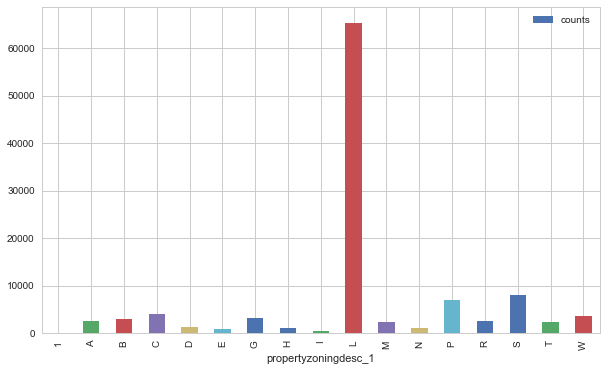

In [24]:
# 첫글자로 새로운 변수 만들기 (첫 글자로 카테고리화)
merged["propertyzoningdesc_1"] = merged["propertyzoningdesc"].astype("str").apply(lambda x: x[:1])
merged["propertyzoningdesc_1"][merged["propertyzoningdesc_1"] == "n"] = np.nan
propertyzoningdesc_1 = pd.DataFrame(merged["propertyzoningdesc_1"])
propertyzoningdesc_1 = propertyzoningdesc_1.groupby("propertyzoningdesc_1").size().reset_index(name='counts')
propertyzoningdesc_1.plot(x = 'propertyzoningdesc_1', y = 'counts', kind = 'bar', figsize=(10, 6))
plt.show()

#### **3) 집 구조 등에 대한 변수들**
- 전체 리스트: bathroomcnt, calculatedbathnbr, threequarterbathnbr, fullbathcnt, numberofstories, roomcnt, bedroomcnt, unitcnt, yearbuilt 

#### **4) 집의 기타 특징(유틸리티 등)에 대한 변수들**
- 전체 리스트: heatingorsystemtypeid, airconditioningtypeid, hashottuborspa, fireplacecnt, fireplaceflag, poolcnt, poolsizesum, pooltypeid10, pooltypeid2, pooltypeid7
- fireplacecnt, poolcnt는 count 변수
- heating/airconditioning type은 카테고리 변수
- hashottuborspa,  pooltypeid10, pooltypeid2, pooltypeid7는 dummy 변수

#### **5) 집의 면적에 대한 변수들**
- basementsqft, finishedfloor1squarefeet, calculatedfinishedsquarefeet, finishedsquarefeet6, finishedsquarefeet12, finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, yardbuildingsqft17, yardbuildingsqft26, garagecarcnt, garagetotalsqft, lotsizesquarefeet

##### 6) tax와 관련된 변수들 (total 7)
- taxvaluedollarcnt
- structuretaxvaluedollarcnt
- landtaxvaluedollarcnt
- taxamount
- assessmentyear
- taxdelinquencyflag
- taxdelinquencyyear

##### (6)-6.  & taxdelinquencyyear & taxdelinquencyyear
- taxdelinquencyflag: 재산세 미납 여부 → NaN값은 미납되지 않았다고 간주, 0으로 imputation
- taxdelinquencyyear: Year for which the unpaid propert taxes were due (미납 된 재산세 (예정이었던) 납부시기)

In [25]:
merged["taxdelinquencyyear_past"] = merged["transaction_year"] - merged["taxdelinquencyyear"]
merged['taxdelinquencyyear_past'].value_counts().reset_index()

,index,taxdelinquencyyear_past
0,2.0,2188
1,3.0,1011
2,1.0,518
3,4.0,341
4,5.0,198
5,6.0,187
6,7.0,129
7,8.0,71
8,9.0,22
9,10.0,13


### 2.4 Relationship between Logerror and variables

#### **1) 집의 위치, 지역 등 지리정보와 관련된 변수들**
- 전체 리스트: fips, latitude, longitude, rawcensustractandblock, censustractandblock, regionidcounty, regionidcity, regionidzip, regionidneighborhood

In [26]:
geo_cat = ["fips", "regionidcounty", "raw_census_1", "census_1", "raw_census_2", "census_2",
           "raw_census_3", "census_3", "regionidcity", "regionidzip", "regionidneighborhood"]

# fig, ax = plt.subplots(3, 4, figsize = (20, 20))

# for idx, n in enumerate(geo_cat):
#     sns.barplot(x = n, y='logerror', data = merged, ax = ax[idx//4, idx % 4])
#     ax[idx// 4, idx % 4].set(yticklabels=[])
    
#     continue

#### **2) 건물 특징, 타입 등에 대한 변수들**
- 전체 리스트: architecturalstyletypeid, decktypeid, buildingqualitytypeid, buildingclasstypeid, storytypeid, typeconstructiontypeid, propertycountylandusecode, propertylandusetypeid, propertyzoningdesc

In [27]:
bdg_cat =  ["architecturalstyletypeid", "decktypeid", "buildingqualitytypeid", "buildingclasstypeid", "storytypeid",
           "typeconstructiontypeid", "propertycountylandusecode", "propertylandusetypeid", "propertyzoningdesc", "propertyzoningdesc_1"]

# fig, ax = plt.subplots(3, 4, figsize = (20, 20))

# for idx, n in enumerate(bdg_cat):
#     sns.barplot(x = n, y='logerror', data = merged, ax = ax[idx // 4, idx % 4])
#     ax[idx // 4, idx % 4].set(yticklabels=[])
    
#     continue

#### **3) 집 구조 등에 대한 변수들**
- 전체 리스트: bathroomcnt, calculatedbathnbr, threequarterbathnbr, fullbathcnt, numberofstories, roomcnt, bedroomcnt, unitcnt, yearbuilt 

In [28]:
strt_var = ["bathroomcnt", "calculatedbathnbr", "threequarterbathnbr", "fullbathcnt", "numberofstories", "roomcnt", "bedroomcnt", "unitcnt"]

# fig, ax = plt.subplots(2,4, figsize = (20,20))

# for idx, n in enumerate(strt_var):
#     sns.regplot(x=n, y='logerror', data=merged, ax = ax[idx // 4,idx % 4])
#     ax[idx // 4, idx % 4].set(yticklabels=[])
#     continue

#### **4) 집의 기타 특징(유틸리티 등)에 대한 변수들**
- 전체 리스트: heatingorsystemtypeid, airconditioningtypeid, hashottuborspa, fireplacecnt, fireplaceflag, poolcnt, poolsizesum, pooltypeid10, pooltypeid2, pooltypeid7
- "poolsizesum"을 빼고 묶어 살펴봄

In [29]:
utl_cat = ["heatingorsystemtypeid", "airconditioningtypeid", "hashottuborspa", "fireplacecnt", "fireplaceflag", "poolcnt", 
           "pooltypeid10", "pooltypeid2", "pooltypeid7"]

# fig, ax = plt.subplots(3, 3, figsize = (20, 20))

# for idx, n in enumerate(utl_cat):
#     sns.barplot(x = n, y='logerror', data = merged, ax = ax[idx // 3, idx % 3])
#     ax[idx // 3, idx % 3].set(yticklabels=[])
#     ax[idx // 3, idx % 3].set(xticklabels=[])
#     continue

#### **5) 집의 면적에 대한 변수들**

In [30]:
sqft_vars = ["basementsqft", "calculatedfinishedsquarefeet", "finishedfloor1squarefeet", "finishedsquarefeet6",
           "finishedsquarefeet12", "finishedsquarefeet13", "finishedsquarefeet15", "finishedsquarefeet50", "yardbuildingsqft17",
           "yardbuildingsqft26", "garagecarcnt", "garagetotalsqft", "lotsizesquarefeet"]

# fig, ax = plt.subplots(4,4, figsize = (20,20))

# for idx, n in enumerate(sqft_vars):
#     if n == 'logerror':
#         continue
#     sns.regplot(x=n, y='logerror', data=merged, ax = ax[idx//4,idx%4])
#     ax[idx//4, idx%4].set(yticklabels=[])
#     ax[idx//4, idx%4].set(xticklabels=[])
#     continue

#### **6) tax와 관련된 변수들**

In [31]:
tax_var = ['taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag']

# fig, ax = plt.subplots(2,3, figsize = (12,8))

# for idx, n in enumerate(tax_var):
#     if n == 'logerror':
#         continue
#     sns.regplot(x=n, y='logerror', data=merged, ax = ax[idx//3,idx%3])
#     ax[idx//3, idx%3].set(yticklabels=[])
#     ax[idx//3, idx%3].set(xticklabels=[])
#     continue

## **3. Feature Engineering**

### 3.1 Missing Values

#### 3.1.1 Status of missing values
- 데이터에 missing value가 상당히 많음, missing value의 비중을 높은 순으로 살펴보자

In [32]:
merged_missing = pd.DataFrame(merged_des["missing_ratio"].sort_values(ascending=False))
merged_missing.reset_index()

,index,missing_ratio
0,buildingclasstypeid,0.999815
1,finishedsquarefeet13,0.999553
2,basementsqft,0.999446
3,storytypeid,0.999446
4,yardbuildingsqft26,0.999017
5,fireplaceflag,0.997653
6,architecturalstyletypeid,0.997212
7,typeconstructiontypeid,0.996891
8,finishedsquarefeet6,0.995193
9,decktypeid,0.992424


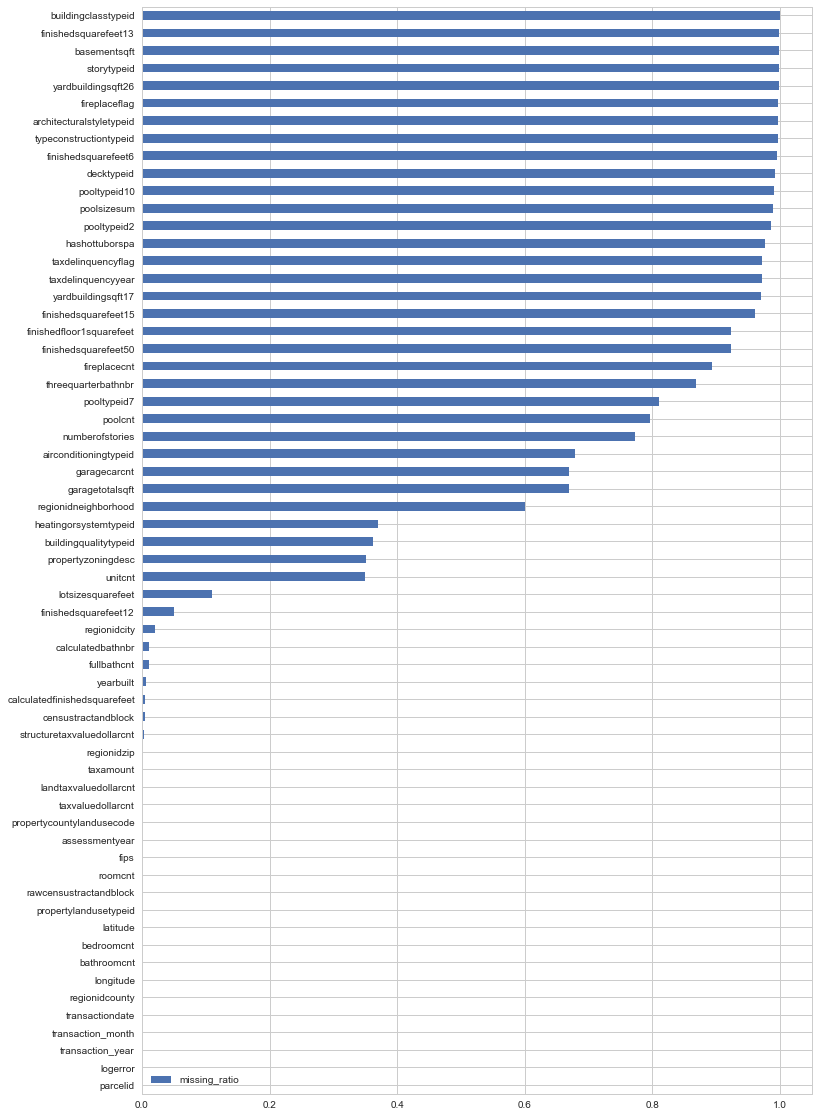

In [33]:
merged_missing.sort_values(by = "missing_ratio", ascending = True).plot(kind = 'barh', figsize=(12,20))

##### Comment:
- missing value ratio가 매우 높은 변수들이 많음
- missing value imputation 방안
    - NaN은 실제로 없어서 그런 것이라고 간주: 0사용
    - 자료가 missing 된 것이라고 볼 경우
        - 연속형 변수: 평균 사용
        - 이산형 변수, 카테고리 변수: 최빈값 사용

#### 3.1.3 Missing Values processing

In [34]:
## 일부 변수 추가 후 categorical / numerical 새로 분류
    ## poolcnt는 dummy variable로 재분류함 (1, 0)

In [35]:
vars = merged_des.reset_index()["index"].tolist()

cat_vars = ['transactiondate','rawcensustractandblock', 'censustractandblock', "raw_census_1", "census_1",
            "raw_census_2", "census_2", "raw_census_3", "census_3", 'regionidcounty', 'regionidcity', 'regionidcounty', 'regionidzip',
            'regionidneighborhood', 'architecturalstyletypeid', 'decktypeid', 'buildingqualitytypeid', 'buildingclasstypeid',
            'storytypeid', 'typeconstructiontypeid', 'propertycountylandusecode', 'propertylandusetypeid',
            'propertyzoningdesc', "propertyzoningdesc_1", 'taxdelinquencyflag', 'taxdelinquencyyear', 'assessmentyear',
            'heatingorsystemtypeid', 'airconditioningtypeid', 'hashottuborspa', 'fireplaceflag', 'pooltypeid10', 'pooltypeid2',
            'pooltypeid7', 'poolcnt']
num_vars = [i for i in vars if i not in cat_vars]

num_vars.remove('parcelid')
num_vars.remove('logerror')

print("number of categorical variables:", len(cat_vars))
print("number of numerical variables:", len(num_vars))

number of categorical variables: 35
number of numerical variables: 33


In [36]:
merged_1 = merged.copy()
merged_1.tail()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,transaction_year,transaction_month,census_1,raw_census_1,census_2,raw_census_2,census_3,raw_census_3,propertyzoningdesc_1,taxdelinquencyyear_past
167883,10833991,-0.002245,2017-09-20,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,2017,9,6037,6037,131900,1319.00,1,1,L,NaN
167884,11000655,0.020615,2017-09-20,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,2017,9,6037,6037,101400,1014.00,1,1,L,NaN
167885,17239384,0.013209,2017-09-21,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,2017,9,6111,6111,008402,0084.02,0,0,NaN,NaN
167886,12773139,0.037129,2017-09-21,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,2017,9,6037,6037,433802,4338.02,4,4,S,NaN
167887,12826780,0.007204,2017-09-25,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,2017,9,6037,6037,503402,5034.02,5,5,W,NaN


#### (1) numerical variables:

##### 집 면적에 관련된 실수 변수
- imputation을 어떻게 할 거라는 설명!

In [37]:
## 위에 한꺼번에 그래프 그리는 부분에서 한번 정의 해준 부분인데 다시 확실히
sqft_vars = ["basementsqft", "calculatedfinishedsquarefeet", "finishedfloor1squarefeet", "finishedsquarefeet6",
           "finishedsquarefeet12", "finishedsquarefeet13", "finishedsquarefeet15", "finishedsquarefeet50", "yardbuildingsqft17",
           "yardbuildingsqft26", "garagecarcnt", "garagetotalsqft", "lotsizesquarefeet"]

In [38]:
def processing_feet_dfX_MV():
    for feature in sqft_vars:
        if feature == 'garagecarcnt':
            merged_1[feature] = merged_1[feature].fillna(1)
        elif feature == 'garagetotalsqft':
            merged_1["garagetotalsqft"] = \
            merged_1["garagetotalsqft"].fillna(float("{:.1f}".format(merged_des.loc['garagetotalsqft'].loc['mean'])))
        else:
            merged_1[feature] = merged_1[feature].fillna(0)

In [39]:
processing_feet_dfX_MV()

##### tax에 관련된 실수 변수? (MV ratio가 낮은 것들이었나?)

##### 지리, 건물 특성 변수 중 missing value ratio가 높은 것 (5% 이상인 것)
- buildingqualitytypeid: 평균점수에 가까우면서 최빈값인 7로 imputation

In [40]:
merged_1["buildingqualitytypeid"] = merged_1["buildingqualitytypeid"].fillna(7)

##### 집 구조, 유틸 등에 대한 numerical variable

In [41]:
merged_1["numberofstories"] = merged_1["numberofstories"].fillna(1)
merged_1["roomcnt"] = merged_1["roomcnt"].fillna(1)
merged_1["bedroomcnt"] = merged_1["bedroomcnt"].fillna(3)
merged_1["unitcnt"] = merged_1["unitcnt"].fillna(1)
merged_1["fireplacecnt"] = merged_1["fireplacecnt"].fillna(0)
merged_1["poolsizesum"] = merged_1["poolsizesum"].fillna(0)

#### (2) dummy/categorical variables:

In [42]:
cat_vars

['transactiondate',
 'rawcensustractandblock',
 'censustractandblock',
 'raw_census_1',
 'census_1',
 'raw_census_2',
 'census_2',
 'raw_census_3',
 'census_3',
 'regionidcounty',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'regionidneighborhood',
 'architecturalstyletypeid',
 'decktypeid',
 'buildingqualitytypeid',
 'buildingclasstypeid',
 'storytypeid',
 'typeconstructiontypeid',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'propertyzoningdesc_1',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'assessmentyear',
 'heatingorsystemtypeid',
 'airconditioningtypeid',
 'hashottuborspa',
 'fireplaceflag',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'poolcnt']

##### 지리, 건물 특성 관련 카테고리 변수 중 missing value ratio가 높은 것 (5% 이상인 것)
- regionidneighborhood (0.601008): 위치한 동네 ㅡ 무엇으로 imputation을 할 수 있나?
- architecturalstyletypeid: 최빈값인 7로 imputation
- decktypeid: NaN은 deck이 없다고 간주. 0으로 imputation → 더미변수화
- buildingclasstypeid: 최빈값인 4로 imputation
- storytypeid: 나온 값이 7 하나 뿐. 모두 7로 imputation → 변수의 의미가 없어짐
- typeconstructiontypeid: 최빈값인 6으로 imputation
- propertycountylandusecode: 최빈값인 0100으로 imputation
- propertylandusetypeid: 최빈값인 261로 imputation
- propertyzoningdesc: 최빈값인 LAR1로 imputation
- propertyzoningdesc_1: 최빈값인 L로 imputation

In [43]:
# ls_c_to_s = ['architecturalstyletypeid', 'rawcensustractandblock', 'censustractandblock', 'regionidcounty', 'regionidcity', 'regionidcounty', 'regionidneighborhood',
#              'decktypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid', 'propertylandusetypeid', 'taxdelinquencyyear',
#              'assessmentyear', 'heatingorsystemtypeid', 'airconditioningtypeid']

In [44]:
merged_1["architecturalstyletypeid"] = merged_1["architecturalstyletypeid"].fillna('7')
merged_1["decktypeid"] = merged_1["decktypeid"].fillna(0)
merged_1["decktypeid"] = merged_1["decktypeid"].replace(['66.0'], 1)
merged_1["buildingclasstypeid"] = merged_1["buildingclasstypeid"].fillna('4.0')
merged_1["storytypeid"] = merged_1["storytypeid"].fillna('7.0')
merged_1["typeconstructiontypeid"] = merged_1["buildingclasstypeid"].fillna('6.0')
merged_1["propertycountylandusecode"] = merged_1["propertycountylandusecode"].fillna('0100')
merged_1["propertylandusetypeid"] = merged_1["propertylandusetypeid"].fillna('261.0')
merged_1["propertyzoningdesc"] = merged_1["propertyzoningdesc"].fillna('LAR1')
merged_1["propertyzoningdesc_1"] = merged_1["propertyzoningdesc_1"].fillna('L')

##### 집 구조, 유틸 등에 대한 카테고리 변수
- poolcnt는 더미변수화 시킴

In [45]:
merged_1["heatingorsystemtypeid"] = merged_1["heatingorsystemtypeid"].fillna(2)
merged_1["airconditioningtypeid"] = merged_1["airconditioningtypeid"].fillna(1)
merged_1["poolcnt"] = merged_1["poolcnt"].fillna(0)
merged_1["fireplaceflag"] = merged_1["fireplaceflag"].fillna(0)
merged_1["pooltypeid10"] = merged_1["pooltypeid10"].fillna(0)
merged_1["pooltypeid2"] = merged_1["pooltypeid2"].fillna(0)
merged_1["pooltypeid7"] = merged_1["pooltypeid7"].fillna(0)
merged_1["ppoolsizesum"] = merged_1["poolsizesum"].fillna(0)
merged_1["hashottuborspa"] = merged_1["hashottuborspa"].fillna(0)
merged_1["threequarterbathnbr"] = merged_1["threequarterbathnbr"].fillna(0)

##### 집 면적, tax에 관련된 카테고리 변수

In [46]:
merged_1['taxdelinquencyflag'] = merged_1['taxdelinquencyflag'].fillna(0)
merged_1["taxdelinquencyyear"] = merged_1["taxdelinquencyyear"].fillna(0)
merged_1["taxdelinquencyyear_past"] = merged_1["taxdelinquencyyear_past"].fillna(0)

#### 상범님 추가적인 작업 부분?

In [54]:
# merged["heatingorsystemtypeid"]

In [53]:
# df = pd.DataFrame(columns=["Original","Yes","None"])
# df["Original"] = merged["heatingorsystemtypeid"]
# df

In [55]:
# df["None"] = df[df["Original"] == 13.0]["Original"]
# df2 = df[df["None"] == 13.0]
# df2

In [56]:
# df2 = df[df["Original"] == 13]
# df2

In [57]:
# df.columns[2]

In [58]:
# df2 = df[np.isnan(df["Original"])]
# df2["None"] = 1.0
# df2

#### (3) imputation 후 missing value ratio 다시 체크

In [59]:
merged_1_des = merged_1.describe(include='all').transpose()
merged_1_des["missing_ratio"] = 1-(merged_1_des["count"]/merged_1.shape[0])
merged_1_des["dtype"] = merged_1.dtypes
merged_1_missing = pd.DataFrame(merged_1_des["missing_ratio"].sort_values(ascending=False))
merged_1_missing.reset_index()

,index,missing_ratio
0,regionidneighborhood,0.601008
1,regionidcity,0.0197096
2,fullbathcnt,0.010912
3,calculatedbathnbr,0.010912
4,yearbuilt,0.00631373
5,census_3,0.00527733
6,census_2,0.00527733
7,census_1,0.00527733
8,censustractandblock,0.00527733
9,structuretaxvaluedollarcnt,0.00315091


### 3.2 Feature Correlation

In [60]:
num_df = merged_1[num_vars]

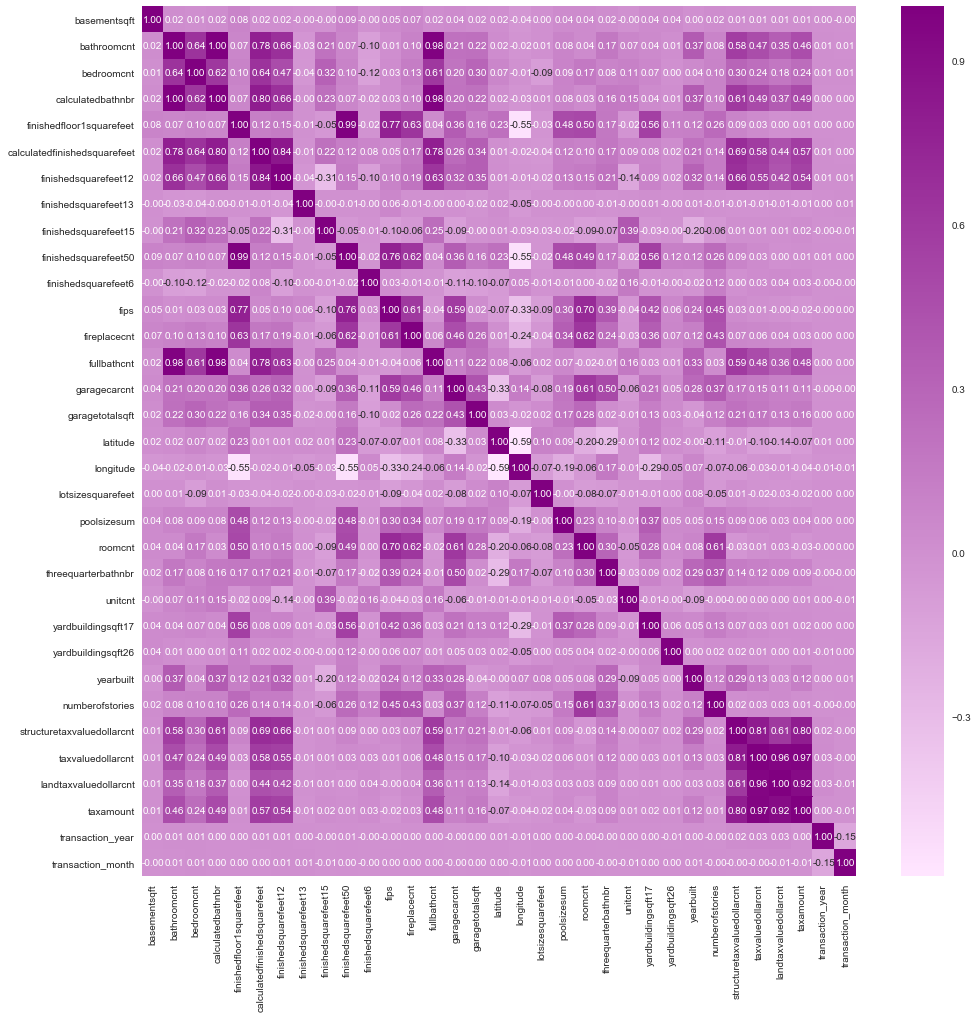

In [61]:
plt.figure(figsize=(16, 16))
cmap = sns.light_palette("purple", as_cmap=True)
sns.heatmap(num_df.corr(), annot=True, fmt='3.2f', cmap=cmap)
plt.show()

#### 3.2.2 Categorical Features

In [62]:
cat_df = merged_1[cat_vars]

In [64]:
cat_df.tail()

,transactiondate,rawcensustractandblock,censustractandblock,raw_census_1,census_1,raw_census_2,census_2,raw_census_3,census_3,regionidcounty,...,taxdelinquencyyear,assessmentyear,heatingorsystemtypeid,airconditioningtypeid,hashottuborspa,fireplaceflag,pooltypeid10,pooltypeid2,pooltypeid7,poolcnt
167883,2017-09-20,60371319.00100601,60371319001006.0,6037,6037,1319.00,131900,1,1,3101.0,...,0.0,2016.0,2.0,1.0,0,0,0.0,0.0,1.0,1.0
167884,2017-09-20,60371014.003002,60371014003002.0,6037,6037,1014.00,101400,1,1,3101.0,...,0.0,2016.0,2.0,1,0,0,0.0,0.0,0.0,0.0
167885,2017-09-21,61110084.022016004,61110084022016.0,6111,6111,0084.02,008402,0,0,2061.0,...,0.0,2016.0,2,1,0,0,0.0,0.0,0.0,0.0
167886,2017-09-21,60374338.02200501,60374338022005.0,6037,6037,4338.02,433802,4,4,3101.0,...,0.0,2016.0,2.0,1.0,0,0,0.0,0.0,0.0,0.0
167887,2017-09-25,60375034.021019995,60375034021020.0,6037,6037,5034.02,503402,5,5,3101.0,...,0.0,2016.0,2.0,1,0,0,0.0,0.0,0.0,0.0


### Hyeshin Modeling

### 3.3 Determination of outliers and variables using OLS model

#### 3.3.1 Model by all numerical Features

#### 3.3.2 Model by all categorical Features

#### 3.3.3 Model by numerical and categorical features together

#### 3.3.4 Model by high correlation coefficient numerical features with Logerror

#### 3.3.5 Model by high correlation coefficient numerical features and categorical features 

#### 3.3.6 Multi-collinearity and variance analysis between variables

##### (1) Multi-collinearity

##### (2) Analysis of variance on categorical features

#### 3.3.7 Comparison of model performance by using variables

### 3.4 Outlier

#### 1) Option1 : IQR (Interquartile Range)

#### 2) Option2 : Standardized resids

#### 3) Option3 : Cook's Distance

#### 4) Check all outliers (option 1,2,3)

#### 5) Combination of outliers groups

### 3.5 Data preprocessing

#### 3.5.1 Select numerical variables

#### 3.5.2 Select categorical variables

## **4. Modeling**

### 4.1. Input data

### 4.2 OLS(Ordinary Least Square) Model

#### 4.2.1 Make OLS Model

#### 4.2.2 ANOVA F-test

#### 4.2.3 RMSE

#### 4.2.4 Normalization of residuals

### 4.3 Predict Logerror